# Autonomous Driving Software Engineering

## Practice 06 - Global Planning

## Global Trajectory Planning on a race track


<br>Agenda:
1. Input and Settings
2. Calculation of Splines
3. Calculation of acceleration + temporal duration profile
4. Overview about the output data
5. Overview about the different algorithms
<br><br>

### For today's practice, we use the Global Trajectory Optimization Algorithm from FTM Github:
https://github.com/TUMFTM/global_racetrajectory_optimization
<br><br><br>

In this exercise, we will calculate global trajectory on a race track with different target objectives. The following figure shows the different paths generated by the different optimization methods:

![track_discretization.png](ADSE/Method_comparison.JPG)

### 1. Input and Settings
First of all we have to import the necessary packages to run our code.

In [1]:
import numpy as np
import time
try:
    import trajectory_planning_helpers as tph
except Exception as _:
    print("install custom package via 'pip install trajectory-planning-helpers'")
import opt_mintime_traj
import matplotlib.pyplot as plt
import helper_funcs_glob
import pandas as pd
import math
from settings import settings
from parser_import import parser_import

ratio = [20, 10]
plt.rcParams["figure.figsize"] = ratio
plt.rcParams.update({"font.size": 24})

The following line defines the vehicle parameter file we use to calculate the trajectory.

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# USER INPUT -----------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# choose vehicle parameter file ----------------------------------------------------------------------------------------
file_paths = {"veh_params_file": "racecar.ini"}


# debug and plot options -----------------------------------------------------------------------------------------------
debug = True  # print console messages
plot_opts = {
    "mincurv_curv_lin": False,  # plot curv. linearization (original and solution based) (mincurv only)
    "raceline": True,  # plot optimized path
    "imported_bounds": False,  # plot imported bounds (analyze difference to interpolated bounds)
    "raceline_curv": True,  # plot curvature profile of optimized path
    "racetraj_vel": True,  # plot velocity profile
    "racetraj_vel_3d": False,  # plot 3D velocity profile above raceline
    "racetraj_vel_3d_stepsize": 1.0,  # [m] vertical lines stepsize in 3D velocity profile plot
    "spline_normals": True,  # plot spline normals to check for crossings
    "mintime_plots": True,
}  # plot states, controls, friction coeffs etc. (mintime only)

The imported track file gives us information about the X and Y Coordinates of the discretization steps and the corresponding track width.

In [3]:
file_paths["track_name"] = "berlin_2018"  # Berlin Formula E 2018

In [4]:
# shortest_path, mincurv, mintime
opt_type = "mintime"

In [5]:
# ----------------------------------------------------------------------------------------------------------------------
# CHECK USER INPUT -----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

if opt_type not in ["shortest_path", "mincurv", "mintime"]:
    raise IOError("Unknown optimization type!")

Import some settings for our optimization step.

In [6]:
imp_opts, mintime_opts, lap_time_mat_opts, file_paths = settings(file_paths, opt_type)

In [7]:
pars, file_paths = parser_import(file_paths, opt_type, mintime_opts)
log = open("params/racecar.ini", "r")
for line in log:
    print(line)

# ----------------------------------------------------------------------------------------------------------------------

[GENERAL_OPTIONS]



### set name of ggv diagram and ax_max_machines files to use

ggv_file="ggv.csv"

ax_max_machines_file="ax_max_machines.csv"



### stepsize options

# stepsize_prep:               [m] used for linear interpolation before spline approximation

# stepsize_reg:                [m] used for spline interpolation after spline approximation (stepsize during opt.)

# stepsize_interp_after_opt:   [m] used for spline interpolation after optimization



stepsize_opts={"stepsize_prep": 1.0,

               "stepsize_reg": 3.0,

               "stepsize_interp_after_opt": 2.0}



### spline regression smooth options

# k_reg:                        [-] order of B-Splines -> standard: 3

# s_reg:                        [-] smoothing factor, range [1.0, 100.0]



reg_smooth_opts={"k_reg": 3,

                 "s_reg": 10}



### preview and review distances fo

![track_discretization.png](ADSE/Centerlin_points.png)

In [8]:
# ----------------------------------------------------------------------------------------------------------------------
# IMPORT TRACK AND VEHICLE DYNAMICS INFORMATION ------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# save start time
t_start = time.perf_counter()

# import track
reftrack_imp = helper_funcs_glob.src.import_track.import_track(
    imp_opts=imp_opts,
    file_path=file_paths["track_file"],
    width_veh=pars["veh_params"]["width"],
)
df = pd.read_csv("./inputs/tracks/berlin_2018.csv")
df.head(10)

,# x_m,y_m,w_tr_right_m,w_tr_left_m
0,216.01,5.1944,5.6174,4.2348
1,216.95,6.2147,5.4200,4.3626
2,217.64,6.9729,5.4223,4.3737
3,218.33,7.7309,5.4228,4.3839
4,219.03,8.4887,5.4220,4.3923
5,219.72,9.2462,5.4206,4.3985
6,220.41,10.0030,5.4183,4.4039
7,221.10,10.7600,5.4149,4.4073
8,221.79,11.5160,5.4117,4.4079
9,222.48,12.2710,5.4084,4.4066


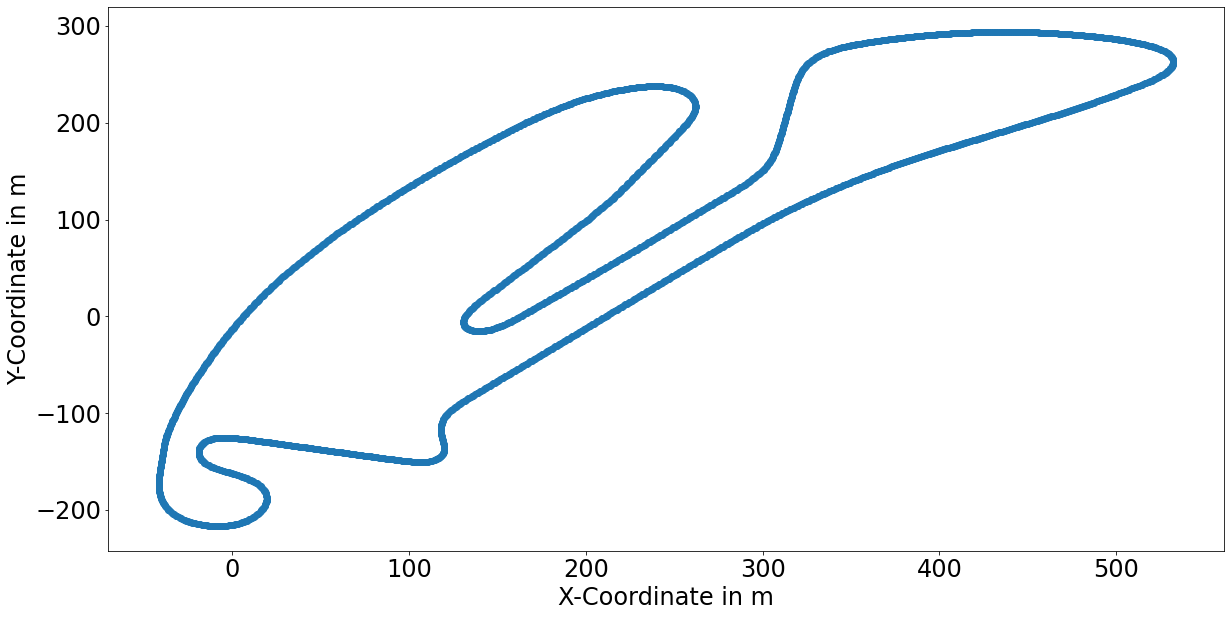

In [9]:
plt.scatter(df["# x_m"].values, df["y_m"].values)
plt.xlabel("X-Coordinate in m")
plt.ylabel("Y-Coordinate in m")
plt.show()

In [10]:
# import ggv and ax_max_machines (if required)
if not (opt_type == "mintime" and not mintime_opts["recalc_vel_profile_by_tph"]):
    ggv, ax_max_machines = tph.import_veh_dyn_info.import_veh_dyn_info(
        ggv_import_path=file_paths["ggv_file"],
        ax_max_machines_import_path=file_paths["ax_max_machines_file"],
    )
else:
    ggv = None
    ax_max_machines = None

print("v_mps,ax_max_mps2,ay_max_mps2")
print(ggv)

v_mps,ax_max_mps2,ay_max_mps2
None


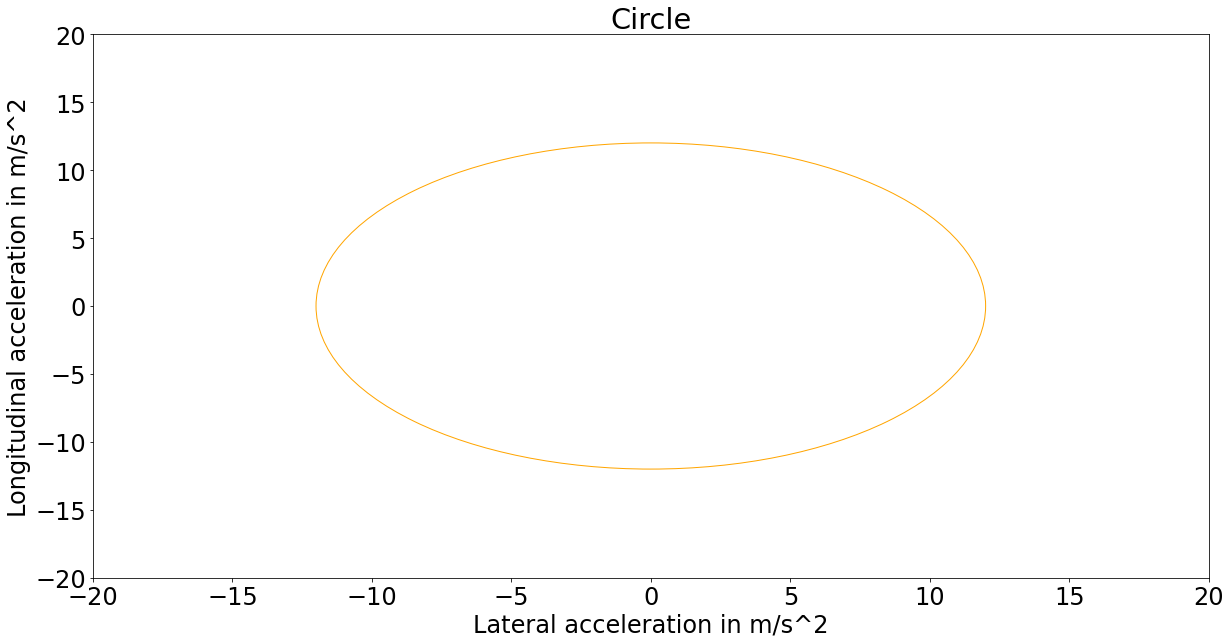

In [11]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((0, 0), 12, fill=False, color="orange")
axes.set(xlim=(-20, 20), ylim=(-20, 20))
axes.add_artist(draw_circle)
plt.title("Circle")
plt.xlabel("Lateral acceleration in m/s^2")
plt.ylabel("Longitudinal acceleration in m/s^2")
plt.show()

In [12]:
print("v_mps,ax_max_machines_mps2")
print(ax_max_machines)

v_mps,ax_max_machines_mps2
None


In [13]:
if not opt_type == "mintime":
    plt.plot(ax_max_machines[:, 0], ax_max_machines[:, 1])
    plt.xlabel("Velocity in m/s")
    plt.ylabel("Maximal acceleration of Engine in m/s^2")
    plt.show()

Noisy data can be smoothed by a spline approximation function

In [14]:
# ------------------------------------------------------------------------------------------------------------------
# INTERPOLATE REFTRACK ---------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# smoothing and interpolating reference track
reftrack_interp = tph.spline_approximation.spline_approximation(
    track=reftrack_imp,
    k_reg=pars["reg_smooth_opts"]["k_reg"],
    s_reg=pars["reg_smooth_opts"]["s_reg"],
    stepsize_prep=pars["stepsize_opts"]["stepsize_prep"],
    stepsize_reg=pars["stepsize_opts"]["stepsize_reg"],
    debug=debug,
)

Spline approximation: mean deviation 0.04m, maximum deviation 0.28m


Because we have a closed race track, the start point corresponds to the end point.

In [15]:
refpath_interp_cl = np.vstack((reftrack_interp[:, :2], reftrack_interp[0, :2]))

### 2. Calculation of Splines

The approach we use is formulated as a QP that can be solved quickly and robustly. The inputs for
the optimisation problem are the centreline points and the corresponding track widths like in the lecture. Within the optimisation problem, we switch from centreline
definition to reference line definition. The difference is that the reference line may have
different track widths on the left and right sides of the line, i.e. it does not have to be in the
middle of the track.

## $\vec r_i = \vec p_i + \alpha_i \vec n_i$

where $\vec p_i = [x_i,y_i]^T$ is the reference line point and $\vec n_i$ the unit length normal vector. The
independent parameter $\alpha_i$ is used to move the point $\vec r_i$ along the normal vector between
the track boundaries.
The raceline is defined by third order spline interpolations of the points $r$ in $x$ and $y$
coordinates. This enables us to calculate first and second order derivatives explicitly from
the spline representation. In the remainder of the sectiononly the $x$-part is described for the
sake of brevity. The $y$-part follows by straightforward extension of the proposed concepts.

![track_discretization.png](ADSE/track_discretization.png)

The optimisation problem is based on a variation of the raceline points r along the reference
line normals, i.e. along the track widths, to minimise the curvature. The notation
of the ith raceline point reads
- After we can formally represent and map our racetrack with our defined discretization steps we have to calculate the splines.
- In variational methods, the path is usually represented by splines, whose parameters are optimised in terms of a cost function. This includes optimisation techniques such as optimal control and geometrical optimisation.
- Solve for curvature continuous cubic splines (spline parameter t) between given points i (splines evaluated at t = 0 and t = 1). The splines must be set up separately for x- and y-coordinate.

## Spline equations:
- ## $P_{x,y}(t)$   =  $a_3 * t^3 +  a_2 * t^2 + a_1 * t + a_0$
- ## $P_{x,y}'(t)$  = $3a_3 * t^2 + 2a_2 * t  + a_1$
- ## $P_{x,y}''(t)$ = $6a_3 * t  + 2a_2$

- ## $t_i(s) = \frac{(s-s_{i0})}{\Delta s_i}$

where $t$ is the normalised curvilinear parameter along one spline segment starting at
the distance $s_{i0}$. Therefore, $0 ≤ t_i ≤ 1$ holds. The spline interpolation requires that consecutive
splines share their respective beginning and endpoint as well as their first and
second derivative at these points.

## Inputs:
- **path**: x and y coordinates as the basis for the spline construction (closed or unclosed). If path is provided unclosed, headings psi_s and psi_e are required!

- **el_lengths**: distances between path points (closed or unclosed). The input is optional. The distances are required for the scaling of heading and curvature values. They are calculated using euclidian distances if required but not supplied.
- **psi_s**: orientation of the {start, end} point.
- **psi_e**: orientation of the {start, end} point.
- **use_dist_scaling**: bool flag to indicate if heading and curvature scaling should be performed. This should be done if the distances between the points in the path are not equal.
Outputs:
- **x_coeff**: spline coefficients of the x-component.
- **y_coeff**: spline coefficients of the y-component.
- **M**: LES coefficients.
- **normvec_normalized**: normalized normal vectors [x, y].

The next code block is the input data of the spline calculation function. In this case we use dummy inputs to illustrate how the function works.

In [16]:
path = refpath_interp_cl
el_lengths = None
psi_s = None
psi_e = None
use_dist_scaling = True

First of all we have to check if our given path is closed or unclosed. In this case we will get a closed path.

In [17]:
if np.all(np.isclose(path[0], path[-1])):
    closed = True
else:
    closed = False
print(closed)

True


If we do not get a closed path and we do not have information about headings we will get an error. In this case we do not have complete information to calculate the spline parameters.

In [18]:
if not closed and (psi_s is None or psi_e is None):
    raise ValueError("Headings must be provided for unclosed spline calculation!")

if el_lengths is not None and path.shape[0] != el_lengths.size + 1:
    raise ValueError("el_lengths input must be one element smaller than path input!")

If distances between path coordinates are not provided but required, calculate euclidean distances as el_lengths.
# $dist_{i+1, i} = \sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2}$

In [19]:
if use_dist_scaling and el_lengths is None:
    el_lengths = np.sqrt(np.sum(np.power(np.diff(path, axis=0), 2), axis=1))
elif el_lengths is not None:
    el_lengths = np.copy(el_lengths)
print(el_lengths)

[2.9980058  2.99800196 2.99800427 2.99801271 2.99802729 2.99804803
 2.99807493 2.99810799 2.99814722 2.99819265 2.99824427 2.99830209
 2.99836615 2.99843644 2.99851298 2.99859579 2.99868488 2.99878028
 2.99888201 2.99899008 2.99910451 2.99922534 2.99935258 2.99948625
 2.99962318 2.99972481 2.99976644 2.99974949 2.99967653 2.99955087
 2.9993765  2.99915812 2.99890116 2.99861174 2.99829671 2.99796361
 2.99762071 2.99727699 2.99694215 2.99662659 2.99634144 2.99609854
 2.99591044 2.9957904  2.9957524  2.99581111 2.99598192 2.9962809
 2.99672387 2.99725894 2.99777867 2.99827038 2.99873165 2.99916011
 2.99955344 2.99990937 3.00022565 3.0005001  3.00073057 3.00091495
 3.00105117 3.00113721 3.0011711  3.00115088 3.00107467 3.0009406
 3.00074686 3.00049167 3.00017328 2.99978999 2.99934016 2.99882214
 2.99823436 2.99760893 2.99708803 2.99669861 2.99642632 2.99625743
 2.99617894 2.9961785  2.99624446 2.99636588 2.99653247 2.99673468
 2.99696363 2.99721114 2.99746972 2.99773261 2.9979937  2.998247

If closed and use_dist_scaling active append element length in order to obtain overlapping elements for proper scaling of the last element afterwards

In [20]:
if use_dist_scaling and closed:
    el_lengths = np.append(el_lengths, el_lengths[0])

Get number of splines: The number of splines is the shape of **path** minus one.

In [21]:
no_splines = path.shape[0] - 1
print(no_splines)

776


Calculate scaling factors between every pair of splines

In [22]:
if use_dist_scaling:
    scaling = el_lengths[:-1] / el_lengths[1:]
else:
    scaling = np.ones(no_splines - 1)
print(scaling)

[1.00000128 0.99999923 0.99999718 0.99999513 0.99999308 0.99999103
 0.99998897 0.99998691 0.99998485 0.99998278 0.99998071 0.99997864
 0.99997656 0.99997447 0.99997238 0.99997029 0.99996819 0.99996608
 0.99996396 0.99996184 0.99995971 0.99995758 0.99995543 0.99995435
 0.99996612 0.99998612 1.00000565 1.00002432 1.00004189 1.00005814
 1.00007281 1.00008568 1.00009652 1.00010507 1.00011111 1.00011439
 1.00011468 1.00011173 1.0001053  1.00009517 1.00008107 1.00006279
 1.00004007 1.00001269 0.9999804  0.99994299 0.99990022 0.99985218
 0.99982148 0.99982663 0.999836   0.99984618 0.99985714 0.99986887
 0.99988135 0.99989458 0.99990853 0.9999232  0.99993856 0.99995461
 0.99997133 0.99998871 1.00000674 1.00002539 1.00004468 1.00006456
 1.00008505 1.00010612 1.00012777 1.00014998 1.00017274 1.00019604
 1.00020864 1.0001738  1.00012995 1.00009087 1.00005637 1.0000262
 1.00000015 0.99997798 0.99995948 0.9999444  0.99993252 0.99992361
 0.99991742 0.99991373 0.99991231 0.99991291 0.99991531 0.99991

## Define linear equation system

$M_{x,y} * a_{x,y} = b_{x,y}$ with $a_{x,y}$ being the desired spline param *4 because of 4 parameters in cubic spline

In [23]:
M = np.zeros((no_splines * 4, no_splines * 4))
b_x = np.zeros((no_splines * 4, 1))
b_y = np.zeros((no_splines * 4, 1))

## Create template for M array entries:
### Row 1: **Beginning** of current spline should be placed on current point (t = 0)
### Row 2: **End** of current spline should be placed on next point (t = 1)
### Row 3: **Heading** at end of current spline should be equal to heading at beginning of next spline (t = 1 and t = 0)
### Row 4: **Curvature** at end of current spline should be equal to curvature at beginning of next spline (t = 1 and t = 0)
<br>

**current point**               | **next point**              | **bounds**

- ### $a_{0, i}$ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp; $=  (x,y)_i$
- ### $a_{0, i} + a_{1, i} +  a_{2, i} +  a_{3, i}$ &emsp;&emsp;&emsp;&emsp;&emsp;&ensp; $ = (x,y)_{i+1}$
- ### &emsp;&emsp;&emsp;$a_{1, i} + 2a_{2, i} + 3a_{3, i}      - a_{1, i+1}$ &nbsp; $= 0$
- ### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$2a_2i + 6a_3i               - 2a_{2, i+1}  = 0$
<br>

In [24]:
template_M = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 2, 3, 0, -1, 0, 0],
        [0, 0, 2, 6, 0, 0, -2, 0],
    ]
)

In the following section we iterate over the number of splines.
- ### $j = 4 * i$ because we jump 4 entries further at each step
- ### The template_M can be used for every iteration
- ### The right-hand side is equal to $(x,y)_i$ and $(x,y)_{i+1}$

In [25]:
for i in range(no_splines):
    j = i * 4

    if i < no_splines - 1:
        M[j : j + 4, j : j + 8] = template_M

        # Clean derivative weighting with scaling
        M[j + 2, j + 5] *= scaling[i]
        M[j + 3, j + 6] *= math.pow(scaling[i], 2)

    else:
        # No curvature and heading bounds on last element (handled afterwards)

        M[j : j + 2, j : j + 4] = [[1, 0, 0, 0], [1, 1, 1, 1]]

    b_x[j : j + 2] = [[path[i, 0]], [path[i + 1, 0]]]
    b_y[j : j + 2] = [[path[i, 1]], [path[i + 1, 1]]]

No curvature and heading bounds on last element (handled afterwards)

## Set boundary conditions for last and first point

If the path is unclosed we want to fix heading at the start and end point of the path -> set heading boundary conditions heading start point. In our case, we have a closed path.

template_M:   <br>&emsp;&emsp;[1,  0,  0,  0,  0,  0,  0,  0]
              <br>&emsp;&emsp;[1,  1,  1,  1,  0,  0,  0,  0]
              <br>&emsp;&emsp;[0,  1,  2,  3,  0, -1,  0,  0]
              <br>&emsp;&emsp;[0,  0,  2,  6,  0,  0, -2,  0]

In [26]:
if closed:
    # heading boundary condition (for a closed spline)
    M[-2, 1] = scaling[-1]
    M[-2, -3:] = [-1, -2, -3]

    # curvature boundary condition (for a closed spline)
    M[-1, 2] = 2 * math.pow(scaling[-1], 2)
    M[-1, -2:] = [-2, -6]

**SOLVE**

- ### np.linalg.solve() --> Solve a linear matrix equation, or system of linear scalar equations.
- ### Solves the full-rank linear equation matrix $M * a = b$
- ### np.squeeze() --> removes single-dimensional entries

In [27]:
x_les = np.squeeze(
    np.linalg.solve(M, b_x)
)  # squeeze removes single-dimensional entries
y_les = np.squeeze(np.linalg.solve(M, b_y))
print(x_les)

[2.16018439e+02 2.02223284e+00 2.38676876e-05 ... 2.02219938e+00
 1.62437920e-05 2.54135090e-06]


- ### Get coefficients of every piece into one row -> reshape
- ### Spline coefficients of the x- and y-components.

In [28]:
coeffs_x_interp = np.reshape(x_les, (no_splines, 4))
coeffs_y_interp = np.reshape(y_les, (no_splines, 4))
print(coeffs_x_interp)

[[2.16018439e+02 2.02223284e+00 2.38676876e-05 3.93744967e-06]
 [2.18040700e+02 2.02228980e+00 3.56799454e-05 3.93701487e-06]
 [2.20063029e+02 2.02237452e+00 4.74910629e-05 3.93641418e-06]
 ...
 [2.09951831e+02 2.02218958e+00 9.95330614e-07 2.54147038e-06]
 [2.11974025e+02 2.02218498e+00 8.61962065e-06 2.54144650e-06]
 [2.13996221e+02 2.02219938e+00 1.62437920e-05 2.54135090e-06]]


- ### Get normal vector (behind used here instead of ahead for consistency with other functions) (second coefficient of cubic splines is relevant for the heading)
- ### np.stack() --> Join a sequence of arrays along a new axis.

In [29]:
normvec = np.stack((coeffs_y_interp[:, 1], -coeffs_x_interp[:, 1]), axis=1)
print(normvec)

[[ 2.21328107 -2.02223284]
 [ 2.21322384 -2.0222898 ]
 [ 2.21314954 -2.02237452]
 ...
 [ 2.21338351 -2.02218958]
 [ 2.21335918 -2.02218498]
 [ 2.21332501 -2.02219938]]


- ### Normalize normal vectors
- ### np.power() --> First array elements raised to powers from second array, element-wise.
- ### $normfactors = \frac{1.0}{\sqrt{a_{1,y}^2+a_{1,x}^2}}$
- ### np.expand_dims() --> Expand the shape of an array.

In [30]:
norm_factors = 1.0 / np.sqrt(np.sum(np.power(normvec, 2), axis=1))
normvec_normalized_interp = np.expand_dims(norm_factors, axis=1) * normvec
print(normvec_normalized_interp)

[[ 0.7382511  -0.67452599]
 [ 0.73823295 -0.67454586]
 [ 0.7382076  -0.6745736 ]
 ...
 [ 0.73827383 -0.67450111]
 [ 0.7382709  -0.67450432]
 [ 0.73826332 -0.67451261]]


- ### Matrix M are the LES (Linear Equation System) Coefficients

In [31]:
a_interp = M
print(M.shape)

(3104, 3104)


- ### Crossings can be solved by smoothing the centerline (draws the line towards the center of the corner --> reference line instead of centerline) or by increasing the discretization step size)

![track_discretization.png](ADSE/Crossings.JPG)

- ### This function checks spline normals for crossings. Returns True if a crossing was found, otherwise False.

In [32]:
# ------------------------------------------------------------------------------------------------------------------
# CHECK SPLINE NORMALS FOR CROSSING POINTS -------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

normals_crossing = tph.check_normals_crossing.check_normals_crossing(
    track=reftrack_interp, normvec_normalized=normvec_normalized_interp, horizon=10
)
print(normals_crossing)

False


In [33]:
if normals_crossing:
    bound_1_tmp = reftrack_interp[:, :2] + normvec_normalized_interp * np.expand_dims(
        reftrack_interp[:, 2], axis=1
    )
    bound_2_tmp = reftrack_interp[:, :2] - normvec_normalized_interp * np.expand_dims(
        reftrack_interp[:, 3], axis=1
    )

    plt.figure(dpi=500)
    plt.rcParams["figure.figsize"] = (16, 10)
    plt.plot(reftrack_interp[:, 0], reftrack_interp[:, 1], "k-")
    for i in range(bound_1_tmp.shape[0]):
        temp = np.vstack((bound_1_tmp[i], bound_2_tmp[i]))
        plt.plot(temp[:, 0], temp[:, 1], "r-", linewidth=0.7)

    plt.grid()
    ax = plt.gca()
    ax.set_aspect("equal", "datalim")
    plt.xlabel("east in m")
    plt.ylabel("north in m")
    plt.title("Error: at least one pair of normals is crossed!")

    plt.show()

    raise IOError(
        "At least two spline normals are crossed, check input or increase smoothing factor!"
    )

1: Mincurv Optimizer uses a QP solver to minimize the summed curvature of a path by moving the path points along their normal vectors within the track width.<br><br>
2: Shortest_path Optimizer uses a QP solver to minimize the summed length of a path by moving the path points along their normal vectors within the track width.<br><br>
3: The Mintime Optimizer problem is described as an optimal control problem, converted to a nonlinear program using direct orthogonal Gauss-Legendre collocation and then solved by the interior-point method IPOPT.<br><br>

In [34]:
# ----------------------------------------------------------------------------------------------------------------------
# CALL OPTIMIZATION ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
pars_tmp = pars

# call optimization
if opt_type == "mincurv":
    alpha_opt = tph.opt_min_curv.opt_min_curv(
        reftrack=reftrack_interp,
        normvectors=normvec_normalized_interp,
        A=a_interp,
        kappa_bound=pars["veh_params"]["curvlim"],
        w_veh=pars["optim_opts"]["width_opt"],
        print_debug=debug,
        plot_debug=plot_opts["mincurv_curv_lin"],
    )[0]

elif opt_type == "shortest_path":
    alpha_opt = tph.opt_shortest_path.opt_shortest_path(
        reftrack=reftrack_interp,
        normvectors=normvec_normalized_interp,
        w_veh=pars["optim_opts"]["width_opt"],
        print_debug=debug,
    )

elif opt_type == "mintime":
    # reftrack_interp, a_interp and normvec_normalized_interp are returned for the case that non-regular sampling was
    # applied
    (
        alpha_opt,
        v_opt,
        reftrack_interp,
        a_interp_tmp,
        normvec_normalized_interp,
    ) = opt_mintime_traj.src.opt_mintime.opt_mintime(
        reftrack=reftrack_interp,
        coeffs_x=coeffs_x_interp,
        coeffs_y=coeffs_y_interp,
        normvectors=normvec_normalized_interp,
        pars=pars_tmp,
        tpamap_path=file_paths["tpamap"],
        tpadata_path=file_paths["tpadata"],
        export_path=file_paths["mintime_export"],
        print_debug=debug,
        plot_debug=plot_opts["mintime_plots"],
    )

    # replace a_interp if necessary
    if a_interp_tmp is not None:
        a_interp = a_interp_tmp

else:
    raise ValueError("Unknown optimization type!")

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CasADi - 2021-06-20 15:19:10 MESSAGE("nlp::init") [..\casadi\core\function_internal.cpp:477]
CasADi - 2021-06-20 15:19:10 MESSAGE("nlp::init") [d:\bld\casadi_1622988450243\work\casadi\core\x_function.hpp:281]
CasADi - 2021-06-20 15:19:10 MESSAGE("nlp::init") [..\casadi\core\mx_function.cpp:102]
CasADi - 2021-06-20 15:19:10 MESSAGE("Using live variables: work array is 6218 instead of 148219") [..\casadi\core\mx_function.cpp:305]
CasADi - 2021-06-20 15:19:11 MESSAGE("solver::init") [..\casadi\core\function_internal.cpp:477]
CasADi - 2021-06-20 15:19:11 MESSAGE("solver::create_function nlp_grad:[x, p, lam:f, lam:g]->[f, g, grad:gamma:x, grad:gamma:p]") [..\casadi\core\oracle_function.cpp:132]
CasADi - 2021-06-20 15:19:14 MESSAGE("solver::create_function nlp_f:[x, p]->[f]") [..\casadi\core\oracle_function.cpp:132]
CasADi - 2021-06-20 15:19:14 MESSAGE("solver::create_function nlp_g:[x, p]->[g]") [..\casadi\core\oracle_function.cpp:132]
CasADi - 2021-06-20 15:19:14 MESSAGE("solver::create_fu

RuntimeError: ..\casadi\core\function_internal.cpp:1832: 'eval_sx' not defined for IpoptInterface

In [35]:
plt.plot(alpha_opt)
plt.xlabel("Discretization steps")
plt.ylabel("Shifting left/right in m")
plt.show()

NameError: name 'alpha_opt' is not defined

- ### This function includes the algorithm part connected to the interpolation of the raceline after the optimization.

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# INTERPOLATE SPLINES TO SMALL DISTANCES BETWEEN RACELINE POINTS -------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

(
    raceline_interp,
    a_opt,
    coeffs_x_opt,
    coeffs_y_opt,
    spline_inds_opt_interp,
    t_vals_opt_interp,
    s_points_opt_interp,
    spline_lengths_opt,
    el_lengths_opt_interp,
) = tph.create_raceline.create_raceline(
    refline=reftrack_interp[:, :2],
    normvectors=normvec_normalized_interp,
    alpha=alpha_opt,
    stepsize_interp=pars["stepsize_opts"]["stepsize_interp_after_opt"],
)

- ### Analytical calculation of heading psi and curvature kappa on the basis of third order splines for x- and y-coordinate.
![track_discretization.png](ADSE/Heading_Curvature.JPG)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# CALCULATE HEADING AND CURVATURE --------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# calculate heading and curvature (analytically)
psi_vel_opt, kappa_opt = tph.calc_head_curv_an.calc_head_curv_an(
    coeffs_x=coeffs_x_opt,
    coeffs_y=coeffs_y_opt,
    ind_spls=spline_inds_opt_interp,
    t_spls=t_vals_opt_interp,
)

- ### The mintime methode already calculated the velocity profile
- ### For the else case: Calculates a velocity profile using the tire and motor limits as good as possible.
- ### np.cumsum() --> Return the cumulative sum of the elements along a given axis.
- ### np.interp(( --> One-dimensional linear interpolation.

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# CALCULATE VELOCITY AND ACCELERATION PROFILE --------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

if opt_type == "mintime" and not mintime_opts["recalc_vel_profile_by_tph"]:
    # interpolation
    s_splines = np.cumsum(spline_lengths_opt)
    s_splines = np.insert(s_splines, 0, 0.0)
    vx_profile_opt = np.interp(s_points_opt_interp, s_splines[:-1], v_opt)

else:
    vx_profile_opt = tph.calc_vel_profile.calc_vel_profile(
        ggv=ggv,
        ax_max_machines=ax_max_machines,
        v_max=pars["veh_params"]["v_max"],
        kappa=kappa_opt,
        el_lengths=el_lengths_opt_interp,
        closed=True,
        filt_window=pars["vel_calc_opts"]["vel_profile_conv_filt_window"],
        dyn_model_exp=pars["vel_calc_opts"]["dyn_model_exp"],
        drag_coeff=pars["veh_params"]["dragcoeff"],
        m_veh=pars["veh_params"]["mass"],
    )

# calculate longitudinal acceleration profile
vx_profile_opt_cl = np.append(vx_profile_opt, vx_profile_opt[0])

### 3. Calculation of acceleration + temporal duration profile

The velocity and acceleration profile is dependent on the calculated optimal race path.
The function calculates the acceleration profile for a given velocity profile.

- ### First check if vx_profile has the right size

In [ ]:
if vx_profile_opt_cl.size != el_lengths_opt_interp.size + 1:
    raise ValueError(
        "Array size of vx_profile should be 1 element bigger than el_lengths!"
    )

- ### Calculate longitudinal acceleration profile array numerically:
- # $a_{x,i} = \frac{((v_{x,i+1})^2 - (v_{x,i})^2)}{2*l}$

In [ ]:
ax_profile_opt = (
    np.power(vx_profile_opt_cl[1:], 2) - np.power(vx_profile_opt_cl[:-1], 2)
) / (2 * el_lengths_opt_interp)
print(ax_profile_opt)

- ### Calculate a temporal duration profile for a given trajectory.

In [ ]:
# Check inputs
if vx_profile_opt.size < el_lengths_opt_interp.size:
    raise ValueError("vx_profile and el_lenghts must have at least the same length!")

if ax_profile_opt is not None and ax_profile_opt.size < el_lengths_opt_interp.size:
    raise ValueError("ax_profile and el_lenghts must have at least the same length!")

- ### Calculate temporal duration of every step between two points
- ### math.isclose() --> Check whether two values are close to each other, or not:
- ### el_lengths_opt_interp --> distance between every two points on interpolated raceline in m

In [ ]:
no_points = el_lengths_opt_interp.size
t_steps = np.zeros(no_points)

$l=v_x*t+\frac{1}{2}*a_x*t^2$

--> $t=\frac{-v_x+\sqrt{2*a_x*l}}{a_x}$

In [ ]:
for i in range(no_points):
    if not math.isclose(ax_profile_opt[i], 0.0):
        t_steps[i] = (
            -vx_profile_opt[i]
            + math.sqrt(
                (
                    math.pow(vx_profile_opt[i], 2)
                    + 2 * ax_profile_opt[i] * el_lengths_opt_interp[i]
                )
            )
        ) / ax_profile_opt[i]

    else:  # ax == 0.0
        t_steps[i] = el_lengths_opt_interp[i] / vx_profile_opt[i]
print(t_steps)

Calculate temporal duration profile out of the given steps. The time duration is calculated by adding up the individual time intervals. For the first node, the time is assumed to be zero.

In [ ]:
t_profile_cl = np.insert(np.cumsum(t_steps), 0, 0.0)

The total lap time can be obtained from the last node.

In [ ]:
print("INFO: Estimated laptime: %.2fs" % t_profile_cl[-1])

In [ ]:
if plot_opts["racetraj_vel"]:
    s_points = np.cumsum(el_lengths_opt_interp[:-1])
    s_points = np.insert(s_points, 0, 0.0)

    plt.plot(s_points, vx_profile_opt)
    plt.plot(s_points, ax_profile_opt)
    plt.plot(s_points, t_profile_cl[:-1])

    plt.grid()
    plt.xlabel("distance in m")
    plt.legend(["vx in m/s", "ax in m/s2", "t in s"])

    plt.show()

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# DATA POSTPROCESSING --------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# arrange data into one trajectory
trajectory_opt = np.column_stack(
    (
        s_points_opt_interp,
        raceline_interp,
        psi_vel_opt,
        kappa_opt,
        vx_profile_opt,
        ax_profile_opt,
    )
)
spline_data_opt = np.column_stack((spline_lengths_opt, coeffs_x_opt, coeffs_y_opt))

# create a closed race trajectory array
traj_race_cl = np.vstack((trajectory_opt, trajectory_opt[0, :]))
traj_race_cl[-1, 0] = np.sum(spline_data_opt[:, 0])  # set correct length

# print end time
print(
    "INFO: Runtime from import to final trajectory was %.2fs"
    % (time.perf_counter() - t_start)
)

# ----------------------------------------------------------------------------------------------------------------------
# CHECK TRAJECTORY -----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
bound1, bound2 = helper_funcs_glob.src.check_traj.check_traj(
    reftrack=reftrack_interp,
    reftrack_normvec_normalized=normvec_normalized_interp,
    length_veh=pars["veh_params"]["length"],
    width_veh=pars["veh_params"]["width"],
    debug=debug,
    trajectory=trajectory_opt,
    ggv=ggv,
    ax_max_machines=ax_max_machines,
    v_max=pars["veh_params"]["v_max"],
    curvlim=pars["veh_params"]["curvlim"],
    mass_veh=pars["veh_params"]["mass"],
    dragcoeff=pars["veh_params"]["dragcoeff"],
)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# EXPORT ---------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------
# export race trajectory  to CSV
if "traj_race_export" in file_paths.keys():
    helper_funcs_glob.src.export_traj_race.export_traj_race(
        file_paths=file_paths, traj_race=traj_race_cl
    )

# if requested, export trajectory including map information (via normal vectors) to CSV
if "traj_ltpl_export" in file_paths.keys():
    helper_funcs_glob.src.export_traj_ltpl.export_traj_ltpl(
        file_paths=file_paths,
        spline_lengths_opt=spline_lengths_opt,
        trajectory_opt=trajectory_opt,
        reftrack=reftrack_interp,
        normvec_normalized=normvec_normalized_interp,
        alpha_opt=alpha_opt,
    )

print("INFO: Finished export of trajectory:", time.strftime("%H:%M:%S"))

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# PLOT RESULTS ---------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# plot results
helper_funcs_glob.src.result_plots.result_plots(
    plot_opts=plot_opts,
    width_veh_opt=pars["optim_opts"]["width_opt"],
    width_veh_real=pars["veh_params"]["width"],
    refline=reftrack_interp[:, :2],
    bound1_imp=None,
    bound2_imp=None,
    bound1_interp=bound1,
    bound2_interp=bound2,
    trajectory=trajectory_opt,
)

## Summary:
- Get an overview about different global trajectory target objectives
- Understand the spline algorithm
- Understand how the calculation of a velocity profile works
- Understand the necessary coditions and parameters
- Get an overview about the results




